# NOTEBOOK 03a: MODELING - Baseline Model

Establishing the baseline model and establishing pipeline for optimization of model hyperparameters. The baseline model represents the most simple informed prediction we can make on the target variable, in this case the mean sale price calculated from the training data. This will be scored by r2 and RMSE to be used for comparison against more sophisticated models ranging from linear regression, Lasso & Ridge regression, ElasticNet, and KNearest Neighbors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import re
import time

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(42)

%matplotlib inline

In [2]:
df = pd.read_csv('../data/train_clean.csv', index_col='Id', na_filter=False)

Loading the clean dataframe from Notebook 02 and confirming correct indexing.

In [3]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,Central Air,...,Misc Feature_none,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,
109,0.0,13517,6,8,1976,2005,289.0,192.0,725.0,1,...,1,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,132.0,276.0,913.0,1,...,1,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,0.0,326.0,1057.0,1,...,1,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,384.0,384.0,1,...,1,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,676.0,676.0,1,...,1,0,0,0,0,0,0,0,0,1


Setting the target and independent variables. We are including all features from the EDA/Preprocesing workflow for initial baseline testing.

In [4]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Baseline model predicting sale price based on the mean sale price from the training data.

In [35]:
base = y_train

Structuring the baseline predictions off y_train to ensure matching shape.

In [38]:
base = base.map(lambda x: np.mean(y_train))
base.head()

Id
372     180368.805863
2234    180368.805863
121     180368.805863
892     180368.805863
2015    180368.805863
Name: SalePrice, dtype: float64

Setting each  baseline prediction to the mean sale price of y_train

In [7]:
r2_score(y_train, base)

0.0

An r2 score of zero shows that we modeling the data with a horizontal line at the mean sale price.

In [8]:
(mean_squared_error(y_train, base))**.5

77682.85736250116

An RMSE of 77657.57 means that at baseline, our predictions are off by an average of \$77657.57.

# Modeling

Setting up a model processing pipeline to run a corse test with a range of values for variance thresholding and automated feature selection using a k-best method. This will help guide identification of colinear features through recursive processing.

This process includes:
- VarianceThreshold: To identify features which may be too sparce to encode enough variance to provide a meaningful signal. 

- StandardScaler: Normalizes the data to ensure beta coefficients are weighted equally across features. This prevents features with high variance to hold priority in regularizing functions such as Lasso, Ridge, or ElasticNet.

- SelectKBest: Selects k-features with the highest f-scores to pass to the model.

- LinearRegression: Fitting a linear model to predict y based on its relationship to each contributing feature.

Later, this workflow will be utilized for selection and optimization of our production model.

In [9]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(0)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=37)),
    ('lr', LinearRegression()), 
#     ('lasso', LassoCV()),
#     ('ridge', RidgeCV()),
#     ('enet', ElasticNetCV()),
#     ('knn', KNeighborsRegressor),
])


Setting the default VarianceThreshold to 0 and k=37, we can measure initial performance before gridsearch optimization.

In [10]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a1ae6b620>)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

Fitting the model to the training data.

In [11]:
pipe.score(X_train,y_train)

0.8398869126205553

R2 score the training data 

In [12]:
pipe.score(X_test,y_test)

0.8835234443636879

R2 score for the testing data. Since the model performed better on the test set we will be mindful of possible underfitting, which may suggest high bias and low variance in our model.

In [14]:
params = {
    'var_thresh__threshold': [0, .001, .01, .02, .05],
    'kbest__k': [5, 7, 13, 17, 23, 37, 53, 79, 101],
#     'lasso__alpha': np.logspace(-3, 3, 7),
}

Setting hyper parameters for the gridsearch cross validation.

In [15]:
gs = GridSearchCV(pipe, params, cv=5, scoring='r2', verbose=1)

Instantiating the model

In [16]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    5.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a1ae6b620>)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_thresh__threshold': [0, 0.001, 0.01, 0.02, 0.05], 'kbest__k': [5, 7, 13, 17, 23, 37, 53, 79, 101]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

Fitting the model to the training data to learn the best parameters. 

In [18]:
gs.best_params_

{'kbest__k': 79, 'var_thresh__threshold': 0}

The model has selected 79 features with a variance threshold of 0. This means that none of the features were excluded due to low signal.

In [21]:
columns = X.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

X_weights = pd.DataFrame(gs.best_estimator_.named_steps['lr'].coef_, 
             index = columns, 
             columns=['weight'])
X_weights['abs_weight'] = X_weights['weight'].abs()

Matching the beta coefficients to the corresponding feature for interpertation.

In [39]:
X_weights.sort_values(['abs_weight'],ascending=False)

,weight,abs_weight
Garage Type_none,-1.494662e+16,1.494662e+16
Garage Finish_Unf,-1.144346e+16,1.144346e+16
Garage Finish_RFn,-1.045403e+16,1.045403e+16
Garage Finish_Fin,-1.000833e+16,1.000833e+16
Garage Qual_none,3.182079e+15,3.182079e+15
Garage Cond_none,3.182079e+15,3.182079e+15
Garage Finish_none,3.182079e+15,3.182079e+15
BsmtFin SF,-2.499910e+15,2.499910e+15
Total Bsmt SF,2.307848e+15,2.307848e+15
Bsmt Unf SF,-2.249778e+15,2.249778e+15


Features such as BsmtFin SF / Bsmt Unf SF / Tot Bsmt SF with very high beta coefficients are indicative of colinearity. These are often coupled with their colinear features which have an inverse counterweight. Based on this model we can identify 10 features that would intuitively encode very similar or identical information. These can be flagged for manual feature elimination to prevent misfitting our model.

In [19]:
def md_coef_table(labels, weights):
    print('| feature | weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels[i]} | {weights[i]:.2e} |')

In [ ]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight']
labels = weights.index

In [20]:
md_coef_table(labels, weights);

| feature | weight |
| --- | --- |
| Gr Liv Area | 7.00e+16 |
| 2nd Flr SF | -5.88e+16 |
| 1st Flr SF | -5.58e+16 |
| BsmtFin SF 1 | 4.96e+16 |
| Total Bsmt SF | -4.82e+16 |
| Bsmt Unf SF | 4.69e+16 |
| BsmtFin SF 2 | 1.80e+16 |
| Low Qual Fin SF | -7.29e+15 |


In [23]:
beta0 = gs.best_estimator_.named_steps['lr'].intercept_
beta0

180367.03643566874

Beta0 for this model was set at 180367.04, meaning that the base price of any home before accounting for features is \$180367.04. This is comparable to the baseline model prediction y-mean = 180368.805863

In [24]:
gs.score(X_train,y_train)

0.8638893157845566

In [25]:
gs.score(X_test,y_test)

0.9032055526486709

The model scored better on the test data than on the training data, suggesting it is likely underfit and suffers from high bias an low variance. This is to be expected considering the exceptionally large beta coefficients that prevent more appropriate features from influencing our predictions.

In [41]:
preds = gs.predict(X_test)

In [42]:
r2_score(preds, y_test)

0.8885004179412322

In [43]:
(mean_squared_error(preds,y_test))**.5

25818.871847281916

This r2 and RMSE are huge improvements over the naive model and align well with the training scores. There is a slight drop but overall the evaluation metrics are better than expected.

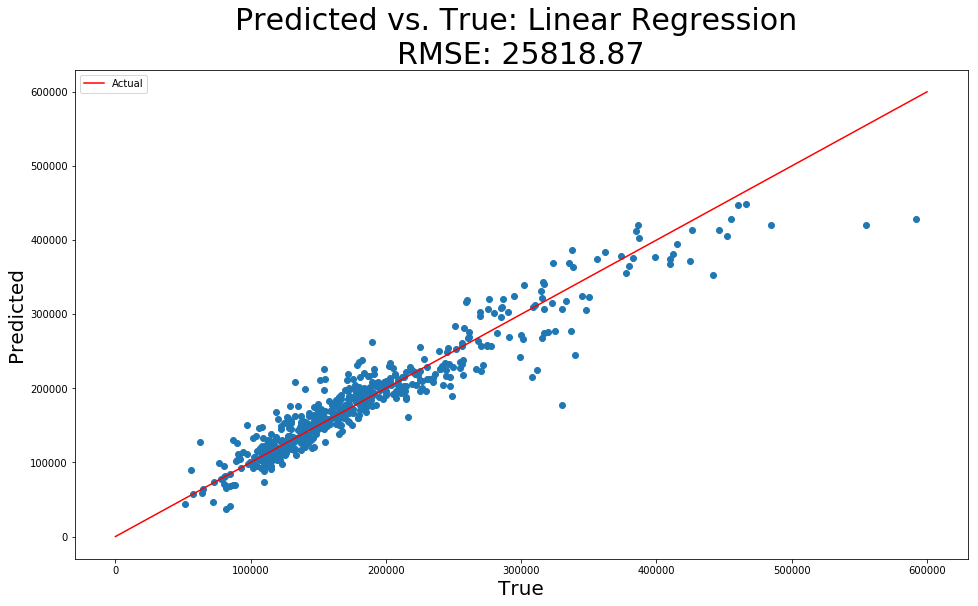

In [26]:
plt.figure(figsize=(16,9))
plt.title(f'Predicted vs. True: Linear Regression \nRMSE: {mean_squared_error(y_test, gs.predict(X_test))**.5:.2f}', fontsize=30);

plt.scatter(y_test, gs.predict(X_test))
plt.plot([0, 600000], [0, 600000], color='r')

plt.ylabel('Predicted', fontsize=20)
plt.xlabel('True', fontsize=20)
plt.legend(['Actual'])
 
    
# plt.savefig('../images/lr_kbest73_preds.png', dpi=300)

In [ ]:
This plot compares predicted vs true values for y.

## Plotting Beta Weights

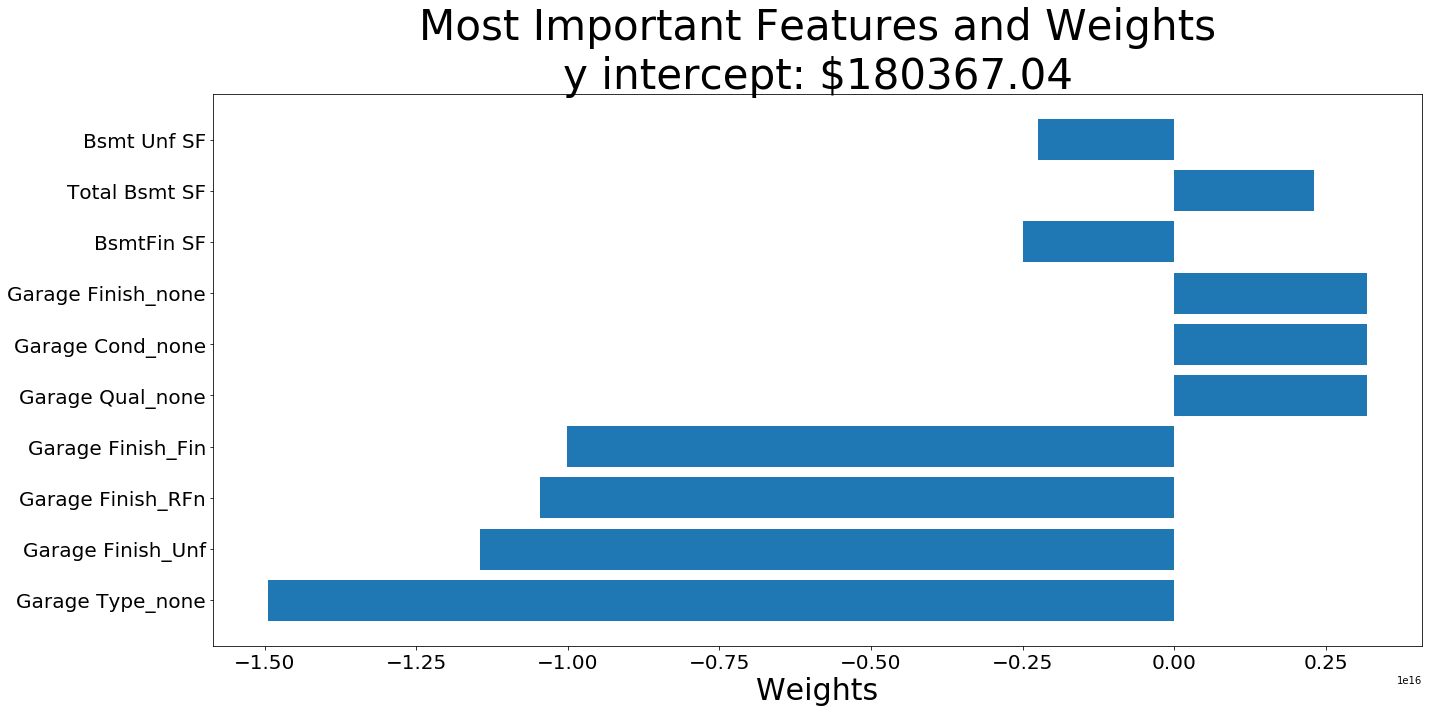

In [47]:
X_weights['abs_weight'] = X_weights['weight'].abs()
weights = X_weights.sort_values('abs_weight', ascending=False)['weight'].head(10)

beta_0 = gs.best_estimator_.named_steps['lr'].intercept_
labels = weights.index

plt.figure(figsize=(20,10))

plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

# plt.savefig('../images/lr_kbest73.png', dpi=300)

7/10 features with the highest impact on our model predictions pertain to the garage. This intuitively makes little sense. The other 3 features all relate to the basement, which helps highlight the impact colinearity can have on model fit.

In [ ]:
X_test.shape

Confirming shape of X_test for alignment with testing data.

# Saving out column names and scaled data for use in future models.

Function to save out files with a clear description of each run. Source: Douglas Strodman.

In [31]:
def filename_format_log(file_path, #path for saving out file of interest
                        logfile='../assets/file_log.txt', #default value
                        now=round(time.time()), #time in epoch time
                        file_description=None): 
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() #regx arg to search string for patterns 
                                                                    #(period not followed or preceeded by a period or follows string)
    except:
        raise NameError('Please enter a relative path with a file extension.') 

    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}' #capture everything to (.) and then add (_) time
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Saving columns that were retained by the model

In [48]:
columns = X_train.columns

In [1]:
formatted_name, now, file_description= filename_format_log('../assets/columns.pkl')

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

NameError: name 'filename_format_log' is not defined

In [33]:
formatted_name, _, _= filename_format_log('../assets/gs.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(gs, f)